In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix as cm, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.14.0
KerasNLP version: 0.6.2


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [22]:
df_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/train.csv")
df_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [3]:

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [13]:
"""
baseline model
"""
df = df_train[['text','target']]

In [17]:
df.dropna(inplace=True)
df.isnull().sum()
X = df['text']
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

<ipython-input-17-34523335921f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


0.797723292469352

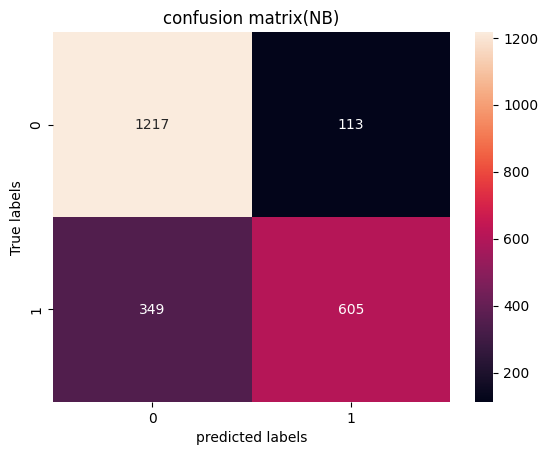

In [18]:
#build ML pipeline - NB
text_pipeline_NB = Pipeline([('tf_idf',TfidfVectorizer()),
                     ('NB',MultinomialNB())])
#Train the model NB
text_pipeline_NB.fit(X_train,y_train)
pred_NB = text_pipeline_NB.predict(X_test)
#Result
cm_NB = cm(y_test,pred_NB)
ax = plt.subplot()
sns.heatmap(cm_NB, annot = True,
            fmt='g',ax=ax)

ax.set_xlabel("predicted labels")
ax.set_ylabel("True labels")
ax.set_title("confusion matrix(NB)")
accuracy_score(y_test,pred_NB)

In [19]:
print(classification_report(y_test, pred_NB))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1330
           1       0.84      0.63      0.72       954

    accuracy                           0.80      2284
   macro avg       0.81      0.77      0.78      2284
weighted avg       0.80      0.80      0.79      2284



0.7841506129597198

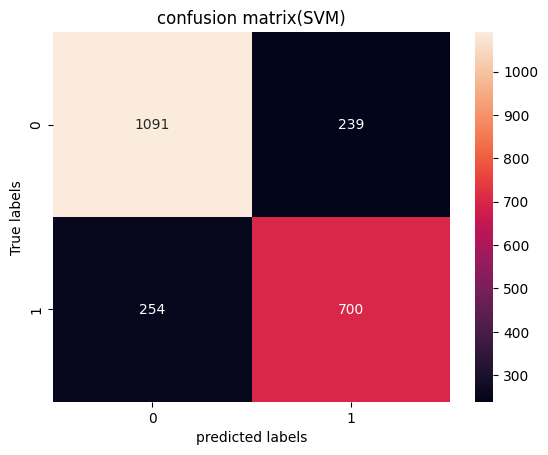

In [20]:
#build ML pipeline - SVM
text_pipeline_svm = Pipeline([('tf_idf',TfidfVectorizer()),
                     ('svm',LinearSVC())])
#Train the model SVM
text_pipeline_svm.fit(X_train,y_train)
pred_svm = text_pipeline_svm.predict(X_test)
#Result
cm_SVM = cm(y_test,pred_svm)
ax = plt.subplot()
sns.heatmap(cm_SVM, annot = True,
            fmt='g',ax=ax)

ax.set_xlabel("predicted labels")
ax.set_ylabel("True labels")
ax.set_title("confusion matrix(SVM)")
accuracy_score(y_test,pred_svm)

In [21]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1330
           1       0.75      0.73      0.74       954

    accuracy                           0.78      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.78      0.78      0.78      2284



In [35]:
"""
tiny_BERT
"""
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.3
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
AUTO = tf.data.experimental.AUTOTUNE

In [36]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=101)

X_test = df_test["text"]

In [37]:
# Load a BERT model.
preset= "bert_small_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(preset)

# Pretrained classifier.
classifier = keras_nlp.models.BertClassifier.from_preset(preset,preprocessor = preprocessor,num_classes=2)
classifier.summary()

Preprocessor: "bert_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer_2 (BertTokenizer)                   │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone_2               │ [(None, 512), (None,      │  28,763,648 │ padding_mask[0][0],            │
│ (BertBackbone)                │ None, 512)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dropout_14 (Dropout)          │ (None, 512)               │           0 │ bert_backbone_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,026 │ dropout_14[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 28,764,674 (109.73 MB)

 Trainable params: 28,764,674 (109.73 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
]
def exponential_decay_fn(epoch):
    return 0.001*0.1**(epoch/20)
ex_decay = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [44]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics= ["accuracy"]
)



In [45]:
# Fit
history = classifier.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=100,validation_data=(X_val, y_val),callbacks=[callbacks,ex_decay])

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 124s 456ms/step - accuracy: 0.5293 - loss: 0.9290 - val_accuracy: 0.5823 - val_loss: 0.7402 - learning_rate: 0.0100
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.5173 - loss: 0.8066 - val_accuracy: 0.5823 - val_loss: 1.0305 - learning_rate: 0.0079
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.5218 - loss: 0.7790 - val_accuracy: 0.5823 - val_loss: 0.8545 - learning_rate: 0.0063
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.5243 - loss: 0.7389 - val_accuracy: 0.5823 - val_loss: 0.7269 - learning_rate: 0.0050
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.5361 - loss: 0.7380 - val_accuracy: 0.4177 - val_loss: 0.9418 - learning_rate: 0.0040
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - accuracy: 0.5192 - loss: 0.7486 - val_accuracy: 0.4177 - val_loss: 0.8221 - learning_rate: 0.0032
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 90s 540ms/step - accur

In [46]:
classifier.evaluate(X_val,y_val)

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5835 - loss: 0.6792


[0.6798069477081299, 0.582311749458313]

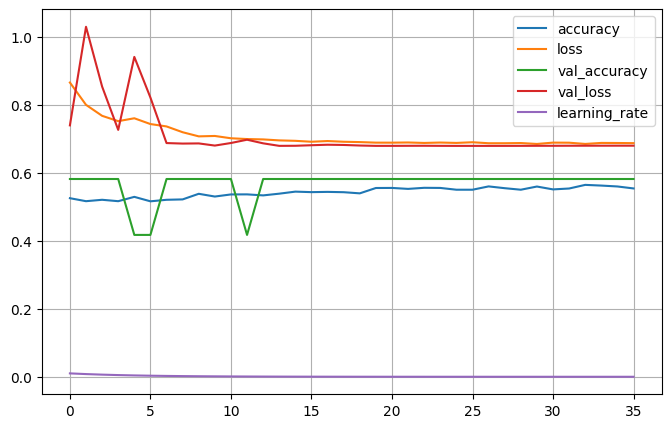

In [47]:
#plot leaning curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()